In [1]:
import os
os.chdir('./..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier


from src.dx5849_training_data_3src import generate_data_dx5849


import warnings
warnings.filterwarnings("ignore")

import shap
import lime
import lime.lime_tabular

def preprocess(X, y, imputation='mean'):
    nor = StandardScaler().fit(X)

    if imputation == 'mean':
        imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X)
        X = imp.transform(X)
    elif imputation == 'zero':
        imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit(X)
        X = imp.transform(X)

    X = nor.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True, stratify=y)

    return X_train, X_test, y_train, y_test

2022-02-17 15:27:56.835125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.2/lib64
2022-02-17 15:27:56.835142: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/dhm/workspace/conference_projects/MICCAI2022_AKF_feature_importance


In [2]:
np.random.seed(0)

# for pred in [0, 6, 12]:
#     data_pos, data_neg = generate_data_dx5849(pred_n_hour=pred, input_n_hour=12, neg_data=True, save_data=True)

data_pos = np.load('processed/patient_data/dx_pred_0_12_3src/data_positive.npy')
data_neg = np.load('processed/patient_data/dx_pred_0_12_3src/data_negative.npy')

# data_neg = data_neg[np.random.choice(data_neg.shape[0], data_pos.shape[0], replace=False)]

X_raw = np.vstack((data_pos, data_neg))
y_raw = [1] * len(data_pos) + [0] * len(data_neg)

# Data preprocessing

In [3]:
X_train, X_test, y_train, y_test = preprocess(X_raw, y_raw)

X_train.shape, X_test.shape, sum(y_train), sum(y_test)

((128403, 52), (14268, 52), 28444, 3161)

# Choose proper tree depth

In [5]:
cv_score_hist = []
val_score_hist = []

for tree_depth in tqdm(range(15, 41)):
    clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_score_hist += [cv_score.mean()]
    
    clf.fit(X_train, y_train)
    val_score = clf.score(X_test, y_test)
    val_score_hist += [val_score]
    print(f'Tree Depth: {tree_depth} - CV Score: {cv_score} - Val Score: {val_score}')

  4%|█▌                                       | 1/26 [03:39<1:31:25, 219.41s/it]

Tree Depth: 15 - CV Score: [0.83851875 0.83427437 0.83657178 0.83800623 0.83520249] - Val Score: 0.8390804597701149


  8%|███▏                                     | 2/26 [10:48<2:17:11, 343.00s/it]

Tree Depth: 16 - CV Score: [0.84069935 0.83466376 0.83719481 0.8404595  0.83679907] - Val Score: 0.8391505466778806


 12%|████▋                                    | 3/26 [14:35<1:51:02, 289.69s/it]

Tree Depth: 17 - CV Score: [0.84256844 0.83711693 0.83836299 0.84119938 0.83862928] - Val Score: 0.8418839360807401


 15%|██████▎                                  | 4/26 [22:30<2:13:01, 362.81s/it]

Tree Depth: 18 - CV Score: [0.84210116 0.83871345 0.84023208 0.8423676  0.83886293] - Val Score: 0.8424446313428652


 19%|███████▉                                 | 5/26 [31:56<2:32:40, 436.23s/it]

Tree Depth: 19 - CV Score: [0.8443207  0.83890814 0.84046571 0.84353583 0.84053738] - Val Score: 0.8430754135127558


 23%|█████████▍                               | 6/26 [36:00<2:03:36, 370.84s/it]

Tree Depth: 20 - CV Score: [0.84393131 0.84011526 0.84077723 0.84345794 0.84073209] - Val Score: 0.8446173254835997


 27%|███████████                              | 7/26 [40:02<1:44:03, 328.62s/it]

Tree Depth: 21 - CV Score: [0.84486585 0.8403489  0.84155601 0.84357477 0.84170561] - Val Score: 0.845878889823381


 31%|████████████▌                            | 8/26 [43:53<1:29:16, 297.61s/it]

Tree Depth: 22 - CV Score: [0.84482691 0.84112768 0.84210116 0.84439252 0.8421729 ] - Val Score: 0.8451780207457247


 35%|██████████████▏                          | 9/26 [47:17<1:16:05, 268.53s/it]

Tree Depth: 23 - CV Score: [0.84529419 0.8412445  0.84108874 0.84345794 0.84116044] - Val Score: 0.8460891505466779


 38%|███████████████▍                        | 10/26 [50:46<1:06:41, 250.12s/it]

Tree Depth: 24 - CV Score: [0.84622873 0.84050465 0.84229586 0.8463785  0.84248442] - Val Score: 0.8460891505466779


 42%|█████████████████▊                        | 11/26 [54:19<59:38, 238.56s/it]

Tree Depth: 25 - CV Score: [0.84544994 0.84062147 0.84299677 0.84579439 0.84205607] - Val Score: 0.847210541070928


 46%|███████████████████▍                      | 12/26 [57:53<53:55, 231.09s/it]

Tree Depth: 26 - CV Score: [0.84568358 0.84221798 0.84256844 0.84583333 0.84162773] - Val Score: 0.8466498458088029


 50%|████████████████████                    | 13/26 [1:03:56<58:46, 271.28s/it]

Tree Depth: 27 - CV Score: [0.84720221 0.84147814 0.8421401  0.84509346 0.84287383] - Val Score: 0.8463694981777404


 54%|████████████████████▍                 | 14/26 [1:11:39<1:05:47, 328.94s/it]

Tree Depth: 28 - CV Score: [0.84677388 0.84132238 0.84276313 0.84591121 0.84225078] - Val Score: 0.8460891505466779


 58%|█████████████████████▉                | 15/26 [1:19:34<1:08:22, 372.98s/it]

Tree Depth: 29 - CV Score: [0.84544994 0.84221798 0.84502161 0.84559969 0.84240654] - Val Score: 0.8470703672553966


 62%|███████████████████████▍              | 16/26 [1:26:39<1:04:47, 388.79s/it]

Tree Depth: 30 - CV Score: [0.84720221 0.84229586 0.84249056 0.84505452 0.8423676 ] - Val Score: 0.847771236333053


 65%|██████████████████████████▏             | 17/26 [1:30:21<50:46, 338.51s/it]

Tree Depth: 31 - CV Score: [0.84552782 0.84155601 0.84268525 0.84676791 0.84139408] - Val Score: 0.8465797589010373


 69%|███████████████████████████▋            | 18/26 [1:34:12<40:49, 306.17s/it]

Tree Depth: 32 - CV Score: [0.84782524 0.84194541 0.84319146 0.84606698 0.84225078] - Val Score: 0.8461592374544435


 73%|█████████████████████████████▏          | 19/26 [1:38:39<34:21, 294.48s/it]

Tree Depth: 33 - CV Score: [0.84583934 0.84136132 0.84272419 0.84563863 0.84330218] - Val Score: 0.8449677600224278


 77%|██████████████████████████████▊         | 20/26 [1:42:45<27:59, 279.94s/it]

Tree Depth: 34 - CV Score: [0.84743585 0.84116662 0.84186753 0.84501558 0.84462617] - Val Score: 0.8462994112699748


 81%|████████████████████████████████▎       | 21/26 [1:46:53<22:31, 270.31s/it]

Tree Depth: 35 - CV Score: [0.84646237 0.84151707 0.8423348  0.84563863 0.84299065] - Val Score: 0.8459489767311467


 85%|█████████████████████████████████▊      | 22/26 [1:50:36<17:04, 256.15s/it]

Tree Depth: 36 - CV Score: [0.84506055 0.84276313 0.84284101 0.84493769 0.84190031] - Val Score: 0.8441968040370059


 88%|███████████████████████████████████▍    | 23/26 [1:54:15<12:15, 245.08s/it]

Tree Depth: 37 - CV Score: [0.84615085 0.84291889 0.84268525 0.84614486 0.84299065] - Val Score: 0.8447574992991309


 92%|████████████████████████████████████▉   | 24/26 [1:58:01<07:58, 239.46s/it]

Tree Depth: 38 - CV Score: [0.84548888 0.84198435 0.84295783 0.84536604 0.84283489] - Val Score: 0.8467900196243342


 96%|██████████████████████████████████████▍ | 25/26 [2:01:51<03:56, 236.60s/it]

Tree Depth: 39 - CV Score: [0.8465013  0.84206222 0.84202329 0.8463785  0.84326324] - Val Score: 0.8455284552845529


100%|████████████████████████████████████████| 26/26 [2:05:52<00:00, 290.49s/it]

Tree Depth: 40 - CV Score: [0.84607297 0.84093299 0.84155601 0.8463785  0.84334112] - Val Score: 0.8455284552845529


ValueError: x and y must have same first dimension, but have shapes (40,) and (26,)

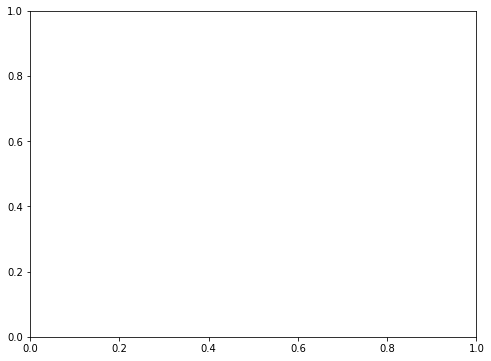

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,41), cv_score_hist, label='CV')
plt.plot(range(1,41), val_score_hist, label='Val.')

ax.set_ylabel("Accuracy")
ax.set_xlabel("Model complexity (Tree depth)")
ax.legend()
fig.tight_layout()

# Feature importance with permutation method

In [4]:
tree_depth=25

clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
clf.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

y_pred = clf.predict(X_test)

METRICS = {
    'acc': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1': f1_score,
    'auroc': roc_auc_score
}

for metric in METRICS:
    print(f'{metric}: {METRICS[metric](y_test, y_pred)}')

acc: 0.836417157275021
recall: 0.3739322999050933
precision: 0.7690305790500976
f1: 0.5031928480204343
auroc: 0.6709852370147598


In [4]:
import pickle

save_model_path = 'models/RF/pred0-impmean-sampling5-41dim.sav'
# pickle.dump(clf, open(save_model_path, 'wb'))
clf = pickle.load(open(save_model_path, 'rb'))

In [5]:
X_shap, _, y_shap, _ = train_test_split(X_test, y_test, train_size=.02, stratify=y_test, random_state=0)
X_shap.shape

(285, 41)

In [7]:
# Create Tree Explainer object that can calculate shap values
shap_explainer = shap.TreeExplainer(clf)
shap_values = shap_explainer.shap_values(X_shap)

np.save('models/RF/pred0-impmean-sampling5-41dim-shap.npy', shap_values)

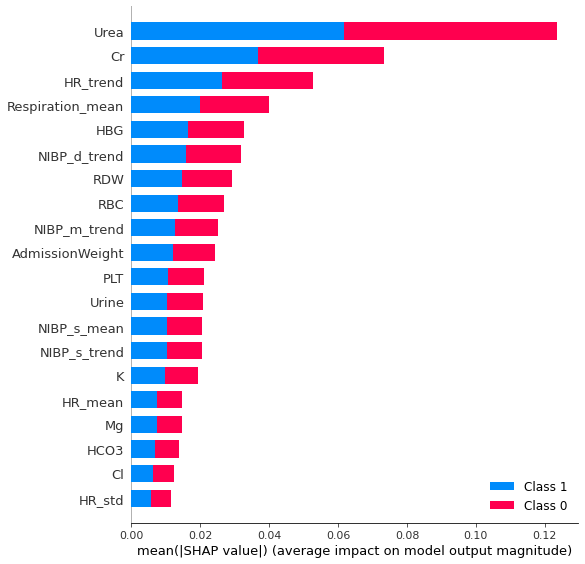

In [8]:
feature_names = [
    'Gender', 'Age', 'AdmissionWeight', 'AdimissionHeight',
    'HR_mean', 'HR_std', 'HR_trend',
    'SpO2_mean', 'SpO2_std', 'SpO2_trend',
    'Respiration_mean', 'Respiration_std', 'Respiration_trend',
    'NIBP_d_mean', 'NIBP_d_std', 'NIBP_d_trend',
    'NIBP_m_mean', 'NIBP_m_std', 'NIBP_m_trend',
    'NIBP_s_mean', 'NIBP_s_std', 'NIBP_s_trend',
    'Urine',
    'GLC', 'K', 'HCO3', 'Na', 'Urea', 'Cr', 'Cl', 'Ca', 'HBG',
    'PLT', 'RBC', 'WBC', 'MCHC', 'MCV', 'MCH', 'RDW', 'Mg', 'MPV',
]

shap.summary_plot(shap_values, X_shap, feature_names=feature_names)

In [7]:
# explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
#                                                    feature_names=feature_names, 
#                                                    class_names=['Neg.', 'Pos.'], 
#                                                    discretize_continuous=True)

# exp = explainer.explain_instance(X_test[0], clf.predict_proba, num_features=10, top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

# exp = explainer.explain_instance(X_test[22], clf.predict_proba, num_features=10, top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

0.8364114245663221


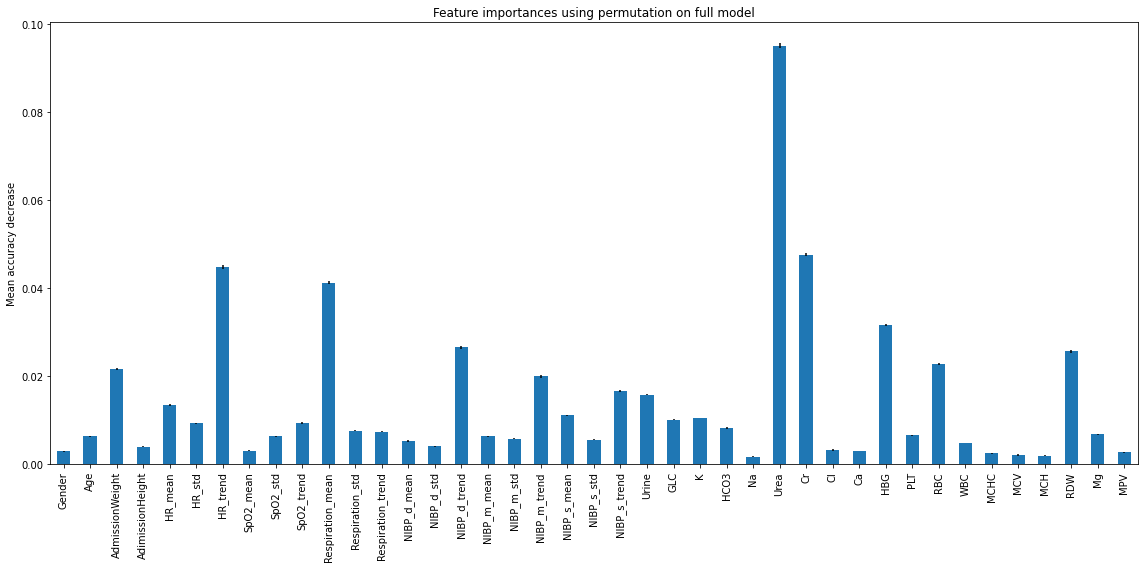

In [5]:
# result = permutation_importance(
#     clf, X_train, y_train, n_repeats=10, random_state=0, n_jobs=8
# )

# feature_names = [
#     'Gender', 'Age', 'AdmissionWeight', 'AdimissionHeight',
#     'HR_mean', 'HR_std', 'HR_trend',
#     'SpO2_mean', 'SpO2_std', 'SpO2_trend',
#     'Respiration_mean', 'Respiration_std', 'Respiration_trend',
#     'NIBP_d_mean', 'NIBP_d_std', 'NIBP_d_trend',
#     'NIBP_m_mean', 'NIBP_m_std', 'NIBP_m_trend',
#     'NIBP_s_mean', 'NIBP_s_std', 'NIBP_s_trend',
#     'Urine',
#     'GLC', 'K', 'HCO3', 'Na', 'Urea', 'Cr', 'Cl', 'Ca', 'HBG',
#     'PLT', 'RBC', 'WBC', 'MCHC', 'MCV', 'MCH', 'RDW', 'Mg', 'MPV',
# ]


# forest_importances = pd.Series(result.importances_mean, index=feature_names)

# fig, ax = plt.subplots(figsize=(16,8))
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()

# SVM

In [7]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

y_pred = clf.predict(X_test)

METRICS = {
    'acc': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1': f1_score,
    'auroc': roc_auc_score
}

for metric in METRICS:
    print(f'{metric}: {METRICS[metric](y_test, y_pred)}')

acc: 0.8127562642369021
recall: 0.21172898689677214
precision: 0.7636887608069164
f1: 0.3315400975853872
auroc: 0.5966621771580418


In [12]:
import pickle

svm_model_file = 'models/SVM/41dim_data.sav'
# pickle.dump(clf, open(svm_model_file, 'wb'))

loaded_model = pickle.load(open(svm_model_file, 'rb'))

In [14]:
feature_names = [
    'Gender', 'Age', 'AdmissionWeight', 'AdimissionHeight',
    'HR_mean', 'HR_std', 'HR_trend',
    'SpO2_mean', 'SpO2_std', 'SpO2_trend',
    'Respiration_mean', 'Respiration_std', 'Respiration_trend',
    'NIBP_d_mean', 'NIBP_d_std', 'NIBP_d_trend',
    'NIBP_m_mean', 'NIBP_m_std', 'NIBP_m_trend',
    'NIBP_s_mean', 'NIBP_s_std', 'NIBP_s_trend',
    'Urine',
    'GLC', 'K', 'HCO3', 'Na', 'Urea', 'Cr', 'Cl', 'Ca', 'HBG',
    'PLT', 'RBC', 'WBC', 'MCHC', 'MCV', 'MCH', 'RDW', 'Mg', 'MPV',
]

# Create Tree Explainer object that can calculate shap values
X_shap, _, y_shap, _ = train_test_split(X_test, y_test, train_size=.002, 
                                        random_state=0, shuffle=True, stratify=y_test)

shap_explainer = shap.KernelExplainer(clf.predict, X_shap)
shap_values = shap_explainer.shap_values(X_shap)

  0%|          | 0/57 [00:00<?, ?it/s]

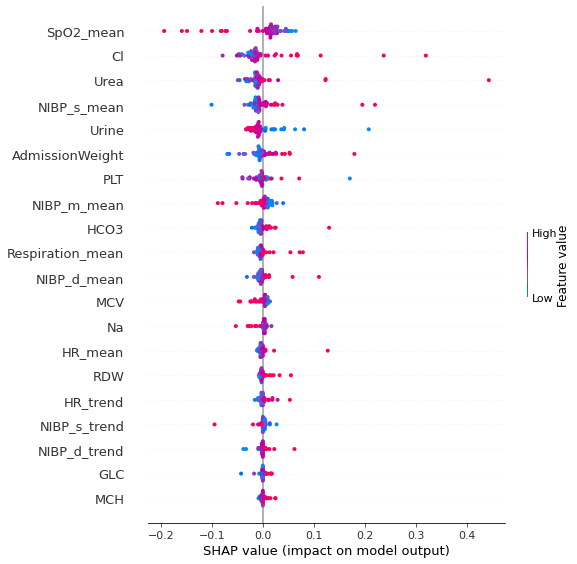

In [23]:
shap.summary_plot(shap_values, X_shap, feature_names=feature_names)

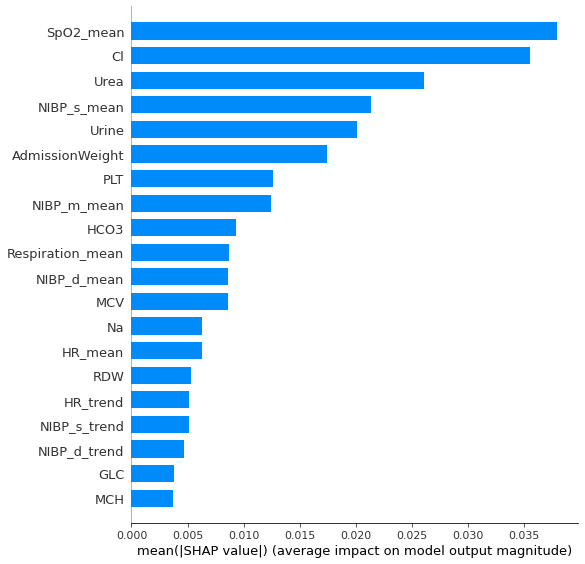

In [24]:
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type='bar')

In [15]:
selected_features = forest_importances.sort_values().iloc[-10:].index.values
print(selected_features)

X_selected = np.empty((X_train.shape[0], len(selected_features)))
X_selected_test = np.empty((X_test.shape[0], len(selected_features)))
for i, feat in enumerate(selected_features):
    feat_idx = feature_names.index(feat)
    X_selected[:, i] = X_train[:, feat_idx]
    X_selected_test[:, i] = X_test[:, feat_idx]
    
clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
scores = cross_val_score(clf, X_selected, y_train, cv=10)

print(np.mean(scores))

clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
clf.fit(X_selected, y_train)
print(clf.score(X_selected_test, y_test))

['HR_mean' 'RBC' 'RDW' 'HBG' 'HCO3' 'HR_trend' 'Respiration_mean' 'Urine'
 'Cr' 'Urea']
0.8177161739852089
0.8181542197935641


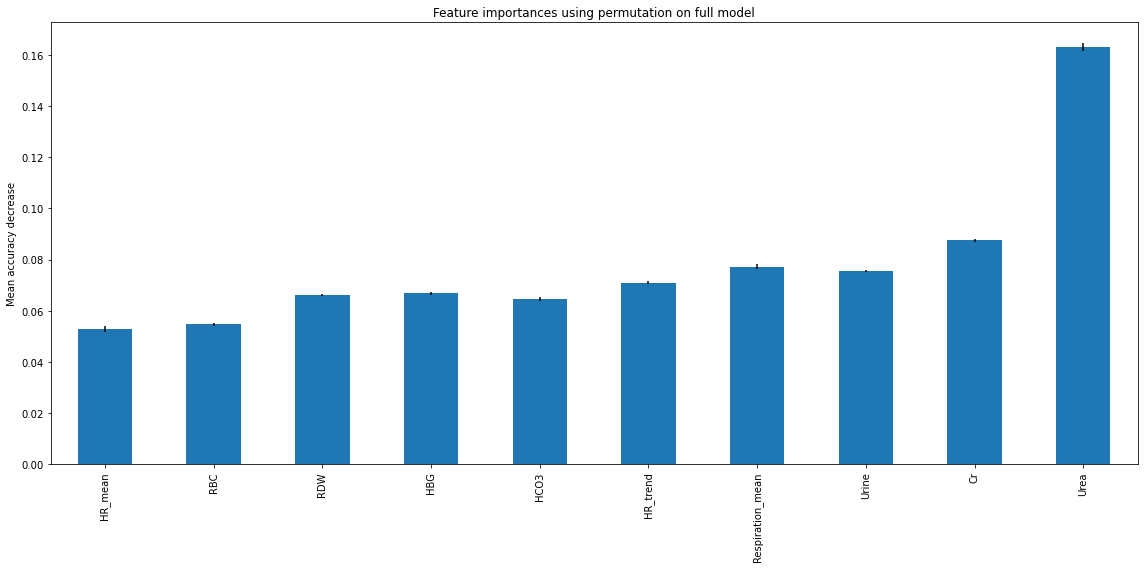

In [16]:
clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
clf.fit(X_selected, y_train)

result = permutation_importance(
    clf, X_selected, y_train, n_repeats=10, random_state=0, n_jobs=8
)

forest_importances = pd.Series(result.importances_mean, index=selected_features)

fig, ax = plt.subplots(figsize=(16,8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

In [10]:
# sudo apt-get install graphviz

from sklearn.tree import export_graphviz
from IPython import display
import os
from tqdm import tqdm

# save_path = '../processed/icd9_5849/dx_pred_0_12_3src/randomForest/'
save_path = '/home/kai/workspace/DHM-ICU/patient_data_analysis/analysis_results/akf/random_forest/tree_structure/'

for i, tree_in_forest in tqdm(enumerate(clf.estimators_)):
    export_graphviz(tree_in_forest,
                    feature_names=selected_features,
                    filled=True,
                    rounded=True,
                    out_file=f'{save_path}tree{i}.dot')
    
    os.system(f'dot -Tpng {save_path}tree{i}.dot -o {save_path}tree{i}.png')

100it [00:30,  3.23it/s]


In [21]:
del X_selected_neg
del X_selected_pos

In [23]:
X_selected_neg.shape

(16468, 10)

In [24]:
X_.shape

(32937, 41)

In [25]:
data_pos.shape, data_neg.shape

((7650, 41), (25287, 41))

# Inter-data correlation

In [27]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_raw)
X_ = imp.transform(X_raw)

nor = Normalizer().fit(X_)
X_ = nor.transform(X_)

X_selected_pos = np.empty((data_pos.shape[0], len(selected_features)))
X_selected_neg = np.empty((data_neg.shape[0], len(selected_features)))
for i, feat in enumerate(selected_features):
    feat_idx = feature_names.index(feat)
    X_selected_pos[:, i] = X_[:data_pos.shape[0], feat_idx]
    X_selected_neg[:, i] = X_[data_pos.shape[0]:, feat_idx]
    
X_selected_pos_df = pd.DataFrame(X_selected_pos, columns=selected_features)
X_selected_neg_df = pd.DataFrame(X_selected_neg, columns=selected_features)

<AxesSubplot:title={'center':'Negative Samples'}>

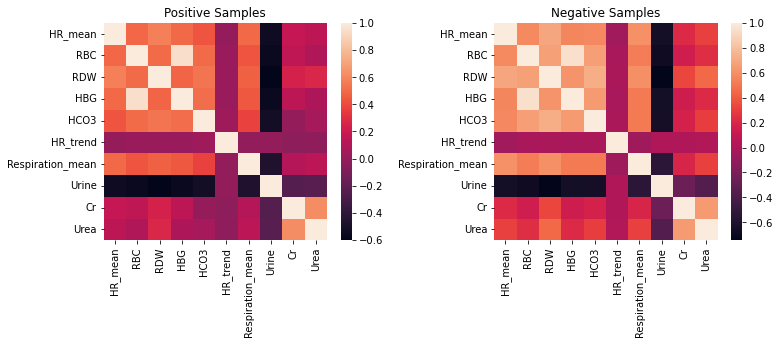

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plt.subplots_adjust(wspace=0.4)
ax[0].set_title('Positive Samples')
ax[1].set_title('Negative Samples')

sns.heatmap(X_selected_pos_df.corr(), ax=ax[0])
sns.heatmap(X_selected_neg_df.corr(), ax=ax[1])

# T-test (inter-category)

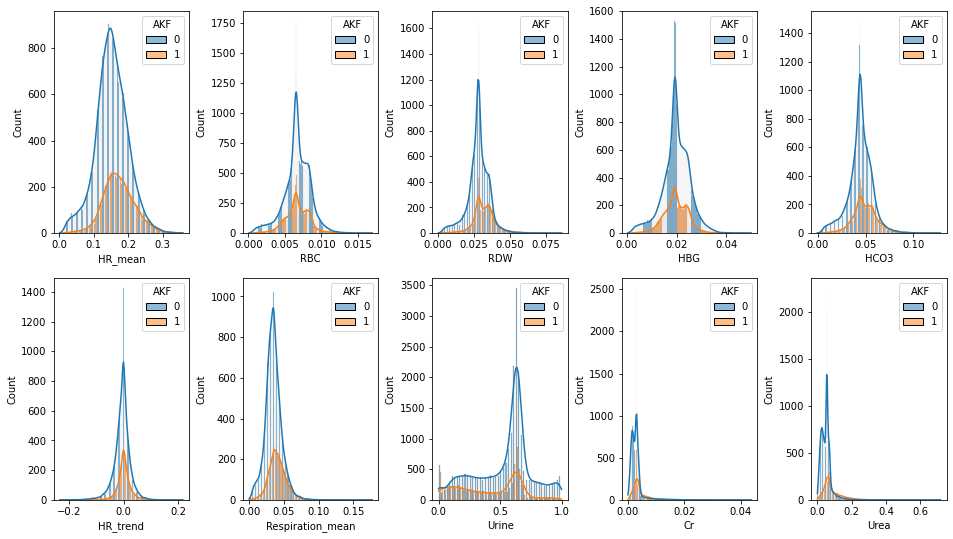

In [30]:
X_selected_pos_df['AKF'] = 1 
X_selected_neg_df['AKF'] = 0

X_selected_df = pd.concat([X_selected_pos_df, X_selected_neg_df], ignore_index=True)
X_selected_df


fig, ax = plt.subplots(2, 5, figsize=(16, 9))
fig.subplots_adjust(wspace=0.4)

for i, feat in enumerate(selected_features):
    sns.histplot(data=X_selected_df, x=feat, hue='AKF',
                 multiple="dodge", shrink=.8, ax=ax[i//5][i%5], kde=True)

In [40]:
t_val, p_val = stats.ttest_ind(X_selected_pos, X_selected_neg, axis=0)

ttest_df = pd.DataFrame(np.vstack((-np.log10(p_val), forest_importances.values)).T, index=selected_features, 
                       columns=['ttest', 'featPerm'])
ttest_df

/tmp/ipykernel_255808/2995607269.py:3: RuntimeWarning: divide by zero encountered in log10
  ttest_df = pd.DataFrame(np.vstack((-np.log10(p_val), forest_importances.values)).T, index=selected_features,


,ttest,featPerm
HR_mean,252.530693,0.052829
RBC,0.621664,0.054632
RDW,inf,0.066253
HBG,1.083325,0.066769
HCO3,196.672029,0.064716
HR_trend,74.586037,0.070898
Respiration_mean,271.657576,0.077206
Urine,inf,0.075650
Cr,inf,0.087514
Urea,inf,0.162959


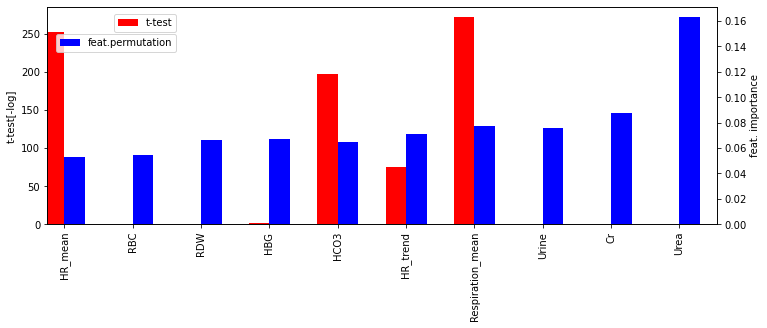

In [42]:
fig, ax = plt.subplots(figsize=(12,4))
ax1 = ax.twinx()

width = 0.3
ttest_df['ttest'].plot(kind='bar', color='red', ax=ax, width=width, position=1, label='t-test')
ttest_df['featPerm'].plot(kind='bar', color='blue', ax=ax1, width=width, position=0, label='feat.permutation')

ttest_plot = ax.set_ylabel('t-test[-log]')
fi_plot = ax1.set_ylabel('feat. importance')
ax.legend(bbox_to_anchor=(0.2, 0.99))
ax1.legend(bbox_to_anchor=(0.2, 0.9))

# predict diagnosis before 1 ~ 12 hours

In [43]:
# data_pos3, data_neg3 = generate_data_dx5849(pred_n_hour=3, input_n_hour=12, neg_data=True)
# data_pos6 = generate_data_dx5849(pred_n_hour=6, input_n_hour=12, neg_data=False)
# data_pos9 = generate_data_dx5849(pred_n_hour=9, input_n_hour=12, neg_data=False)
# data_pos12 = generate_data_dx5849(pred_n_hour=12, input_n_hour=12, neg_data=False)

# data_pos3 = np.load('processed/icd9_5849/dx_pred_3_12_3src/data_positive.npy')
# data_pos6 = np.load('processed/icd9_5849/dx_pred_6_12_3src/data_positive.npy')
# data_pos9 = np.load('processed/icd9_5849/dx_pred_9_12_3src/data_positive.npy')
# data_pos12 = np.load('processed/icd9_5849/dx_pred_12_12_3src/data_positive.npy')

data_neg = np.load('processed/icd9_5849/data_negative.npy')
# data_pos.shape, data_pos3.shape, data_pos6.shape, data_pos9.shape, data_pos12.shape, data_neg.shape

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
np.random.seed(0)

# data_pos_list = [data_pos, data_pos3, data_pos6, data_pos9, data_pos12]

acc_all_feat = []
acc_selected_feat = []
for i in range(13):
    data_p = generate_data_dx5849(pred_n_hour=i, input_n_hour=12, neg_data=False, save_data=False)
    data_n = data_neg[np.random.choice(data_neg.shape[0], data_p.shape[0], replace=False)]
    X_raw = np.vstack((data_p, data_n))
    y_raw = [1] * len(data_p) + [0] * len(data_n)
    X_train, X_test, y_train, y_test = preprocess(X_raw, y_raw)
    
    # all features
    clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
    clf.fit(X_train, y_train)
    acc_all_feat += [clf.score(X_test, y_test)]
    
    # selected features
    selected_features = ['NIBP_s_mean', 'WBC', 'HBG', 'RBC', 'RDW', 'GLC', 
                         'AdmissionWeight', 'Urine', 'Urea', 'Cr',]
    X_selected = np.empty((X_train.shape[0], len(selected_features)))
    X_selected_test = np.empty((X_test.shape[0], len(selected_features)))
    for i, feat in enumerate(selected_features):
        feat_idx = feature_names.index(feat)
        X_selected[:, i] = X_train[:, feat_idx]
        X_selected_test[:, i] = X_test[:, feat_idx]

    clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
    clf.fit(X_selected, y_train)
    acc_selected_feat += [clf.score(X_selected_test, y_test)]

 13%|█████                                   | 486/3864 [00:16<00:58, 58.24it/s]/home/kai/workspace/DHM-ICU/patient_data_analysis/dx5849_training_data_3src.py:141: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  info, data = load_patient_data_dsv(pid)
 13%|█████                                   | 487/3864 [00:18<01:40, 33.50it/s]/home/kai/workspace/DHM-ICU/patient_data_analysis/dx5849_training_data_3src.py:141: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  info, data = load_patient_data_dsv(pid)
 13%|█████                                   | 490/3864 [00:18<01:06, 50.52it/s]/home/kai/workspace/DHM-ICU/patient_data_analysis/dx5849_training_data_3src.py:141: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  info, data = load_patient_data_dsv(pid)
 13%|█████                                   | 486/3864 [00:15<00:56, 59.58it/s]/home

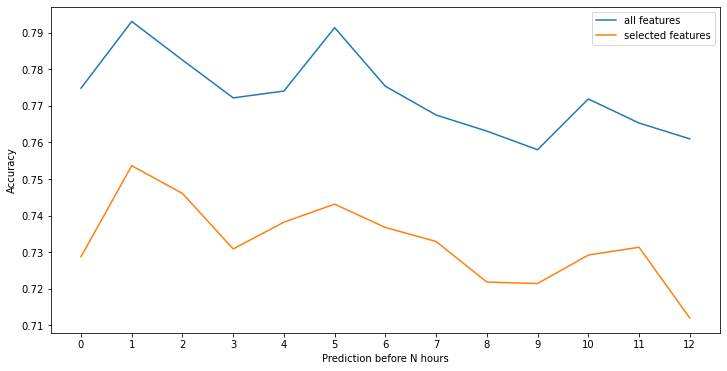

In [46]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(13), acc_all_feat, label='all features')
ax.plot(range(13), acc_selected_feat, label='selected features')
ax.set_xticks(range(13))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Prediction before N hours')
ax.legend()

# Random trees embedding

In [41]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

n_neighbors = 10
n_samples, n_features = X_selected.shape

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
#     "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
#         n_components=2
#     ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
#     "Hessian LLE embedding": LocallyLinearEmbedding(
#         n_neighbors=n_neighbors, n_components=2, method="hessian"
#     ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=100),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
#     "t-SNE embeedding": TSNE(
#         n_components=2, init="pca", learning_rate="auto", random_state=0
#     ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="random", random_state=0
    ),
}

In [42]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X_selected.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X_selected

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...


/home/kai/anaconda3/envs/tf-py38/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:936: LinAlgWarning: Diagonal number 8 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


Computing Random Trees embedding...
Computing Spectral embedding...
Computing NCA embedding...


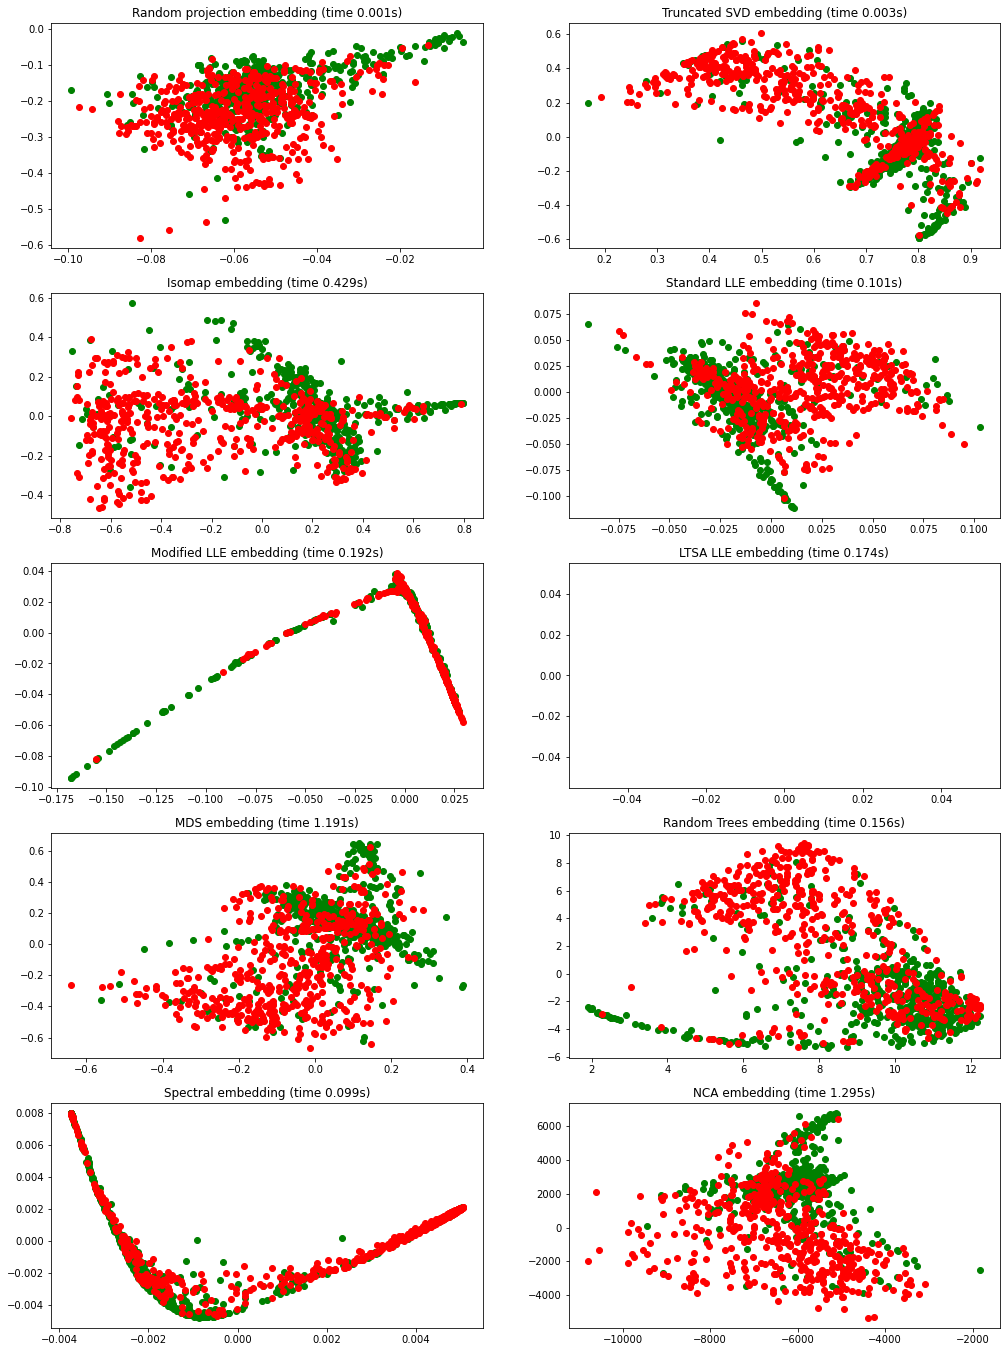

In [58]:
from itertools import zip_longest

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(17, 24))

for name, ax in zip_longest(timing, axs.ravel()):
    if name is None:
        ax.axis("off")
        continue
    title = f"{name} (time {timing[name]:.3f}s)"
    ax.scatter(projections[name][np.array(y)==0, 0], projections[name][np.array(y)==0, 1], c='g')
    ax.scatter(projections[name][np.array(y)==1, 0], projections[name][np.array(y)==1, 1], c='r')
    ax.set_title(title)